In [58]:
import numpy as np
import matplotlib.pyplot as plt
from skbeam.core import utils
from scipy import ndimage
from matplotlib.colors import LogNorm
from datetime import datetime
import xarray as xr

In [59]:
def dssc_correction(module_imgs):
    # order of module_imgs = [15, 0, 8, 7]
    # modified from Lingjia code
    # TODO: double check with Lingjia to make sure the positions are correct
    for i in range(4):
        if i in [1,3]:
            module_imgs[i] = np.flipud(module_imgs[i])
        else:
            module_imgs[i] = np.fliplr(module_imgs[i])
            
    drow = [9,9,2,2,159,159,152,152]
    dcol = [0,264,531,796,8,272,541,805]
    
    dssc_corrected = np.zeros((290,1061))*np.nan
    count = 0
    for i in range(4):
        for j in range(2):
            dssc_corrected[drow[count]:drow[count]+128,dcol[count]:dcol[count]+256] = module_imgs[i][:,256*j:256*j+256]
            count = count+1 
    
    im = dssc_corrected[5:-5,390:-391].copy()
    im[np.isnan(im)] = 0
    x0, y0 = ndimage.measurements.center_of_mass(im)[1], ndimage.measurements.center_of_mass(im)[0]
    center = np.array([x0,y0]).astype(int)
    return center+(390, 5), dssc_corrected


def dssc_corrected_to_module_stack(dssc_corrected):
    # order of module_imgs = [15, 0, 8, 7]
    # TODO: double check with Lingjia to make sure the positions are correct
            
    drow = [9,9,2,2,159,159,152,152]
    dcol = [0,264,531,796,8,272,541,805]
    
    module_imgs = np.zeros((4, 128, 512))*np.nan
    count = 0
    for i in range(4):
        for j in range(2):
            module_imgs[i][:,256*j:256*j+256] = dssc_corrected[drow[count]:drow[count]+128,dcol[count]:dcol[count]+256]
            count = count+1 
            
    for i in range(4):
        if i in [1,3]:
            module_imgs[i] = np.flipud(module_imgs[i])
        else:
            module_imgs[i] = np.fliplr(module_imgs[i])
    
    
    return module_imgs

In [60]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

field = current[0]
run = runNB[0]
group = 0

pm = np.zeros((4, 128, 512))*np.nan
for i, module in enumerate(modules):
    photon_maps_filename = f'/gpfs/exfel/u/scratch/SCS/202201/p002884/LS/Reduced_Data/reduced_3-17-23/r{run:0d}m{module:0d}_{group:1d}_photon.npy'
    photon_maps = np.load(photon_maps_filename, 'r')[:10].mean(axis=(0,1))
    pm[i] = photon_maps

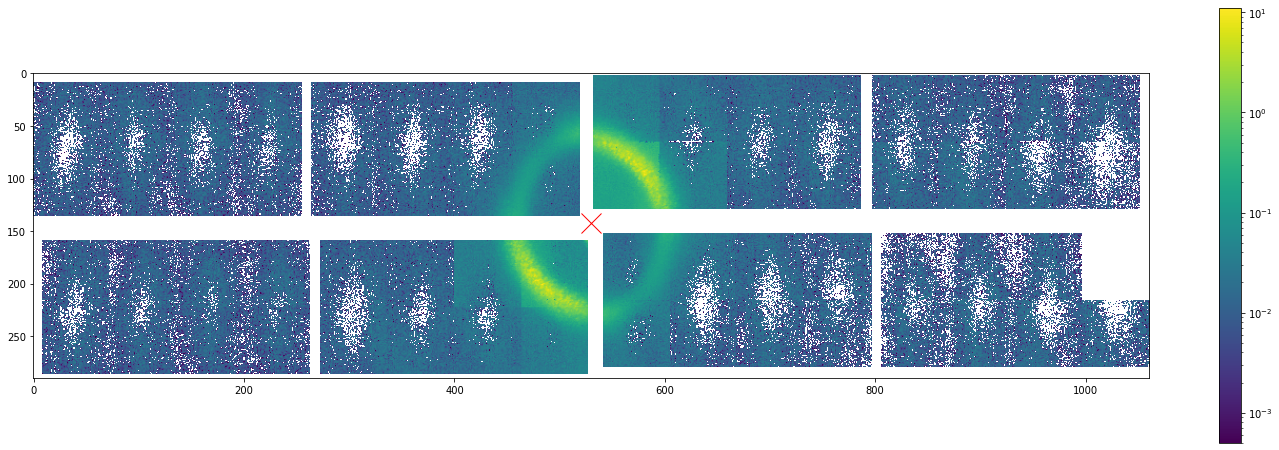

In [61]:
center, img = dssc_correction(pm.copy())

plt.figure(figsize=(25,10))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.show()

In [91]:
shape = img.shape
pixel_size = (204e-6, 236e-6) # m
sample_distance = 2.8 # m
wavelength = (1240/1183) #nm Gd M5

q_grid = utils.twotheta_to_q(utils.radius_to_twotheta(sample_distance, utils.radial_grid(center[::-1], shape, pixel_size)), wavelength)
angle_grid = utils.angle_grid(center[::-1], shape)

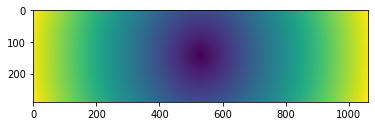

In [92]:
plt.imshow(q_grid)

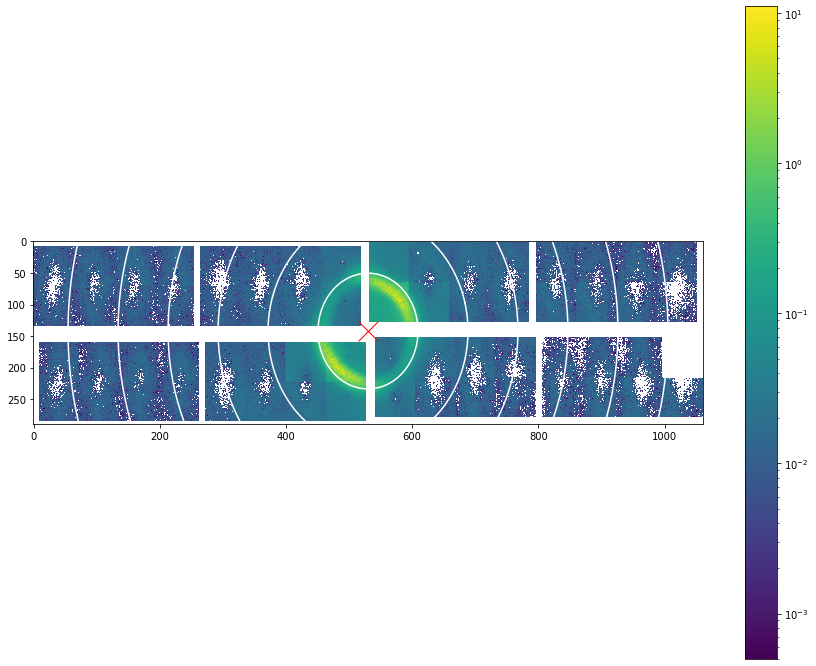

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.contour(q_grid, colors=['w'])
plt.show()

In [135]:
q_bins = np.linspace(np.amin(q_grid), np.amax(q_grid), 50)
angle_bins = np.linspace(np.amin(angle_grid), np.amax(angle_grid), 50)
q_inds = np.digitize(q_grid, q_bins, right=True)
angle_inds = np.digitize(angle_grid, angle_bins, right=True)

q_discrete = np.zeros(q_inds.shape)
for uq in np.unique(q_inds):
    q_discrete[uq==q_inds] = q_bins[uq]
    
angle_discrete = np.zeros(angle_inds.shape)
for ua in np.unique(angle_inds):
    angle_discrete[ua==angle_inds] = angle_bins[ua]

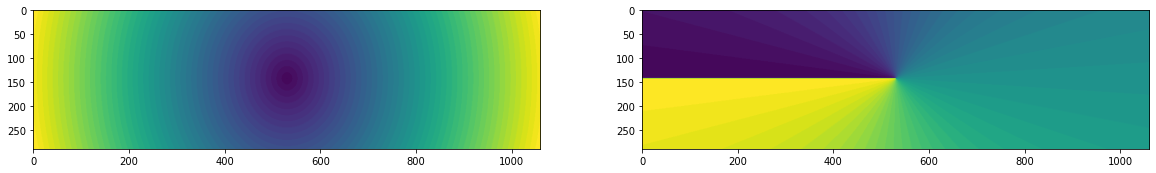

In [136]:
fig, ax= plt.subplots(figsize=(20,10), ncols=2)
ax[0].imshow(q_discrete)
ax[1].imshow(angle_discrete)
plt.show()

In [137]:
grid = q_discrete + angle_discrete * 1000

labels = np.zeros(grid.shape, dtype=int)
for i, u in enumerate(np.unique(grid)):
    labels[grid==u] = i

In [138]:
np.unique(q_discrete), np.unique(angle_discrete)

(array([0.        , 0.00561526, 0.01123051, 0.01684577, 0.02246102,
        0.02807628, 0.03369153, 0.03930679, 0.04492204, 0.0505373 ,
        0.05615255, 0.06176781, 0.06738306, 0.07299832, 0.07861357,
        0.08422883, 0.08984408, 0.09545934, 0.10107459, 0.10668985,
        0.1123051 , 0.11792036, 0.12353561, 0.12915087, 0.13476612,
        0.14038138, 0.14599663, 0.15161189, 0.15722714, 0.1628424 ,
        0.16845765, 0.17407291, 0.17968817, 0.18530342, 0.19091868,
        0.19653393, 0.20214919, 0.20776444, 0.2133797 , 0.21899495,
        0.22461021, 0.23022546, 0.23584072, 0.24145597, 0.24707123,
        0.25268648, 0.25830174, 0.26391699, 0.26953225, 0.2751475 ]),
 array([-3.13970586, -3.0115161 , -2.88332633, -2.75513657, -2.6269468 ,
        -2.49875704, -2.37056727, -2.2423775 , -2.11418774, -1.98599797,
        -1.85780821, -1.72961844, -1.60142868, -1.47323891, -1.34504914,
        -1.21685938, -1.08866961, -0.96047985, -0.83229008, -0.70410032,
        -0.57591055, -0.44

In [139]:
len(np.unique(q_discrete)), len(np.unique(angle_discrete))

(50, 50)

In [140]:
len(np.unique(labels))

1265

In [141]:
labels

array([[ 146,  146,  146, ...,  553,  553,  553],
       [ 146,  146,  146, ...,  553,  553,  553],
       [  97,  146,  146, ...,  553,  553,  553],
       ...,
       [1167, 1167, 1167, ...,  749,  749,  749],
       [1167, 1167, 1167, ...,  749,  749,  749],
       [1167, 1167, 1167, ...,  749,  749,  749]])

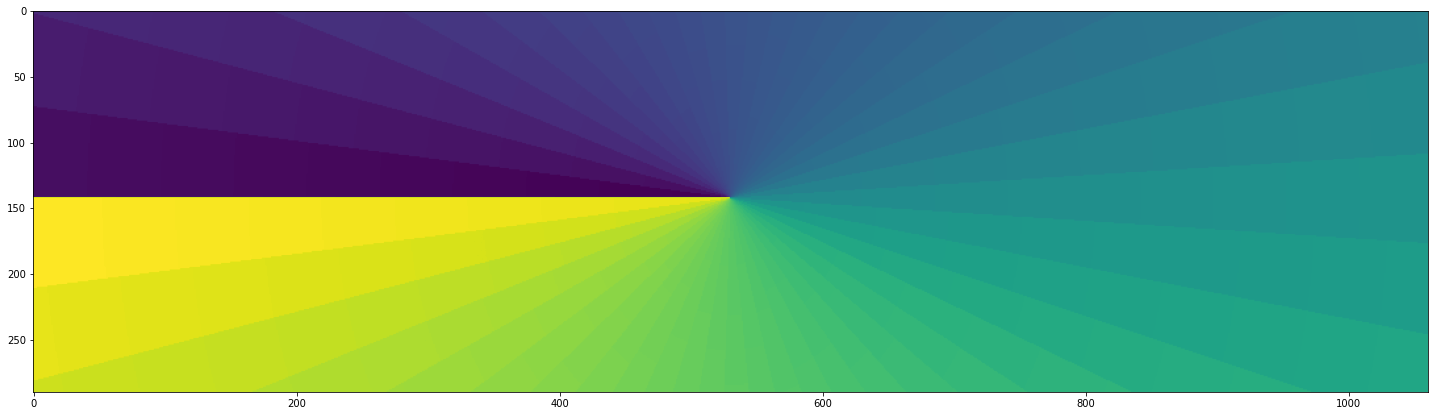

In [142]:
plt.figure(figsize=(25,10))
plt.imshow(labels)
plt.show()

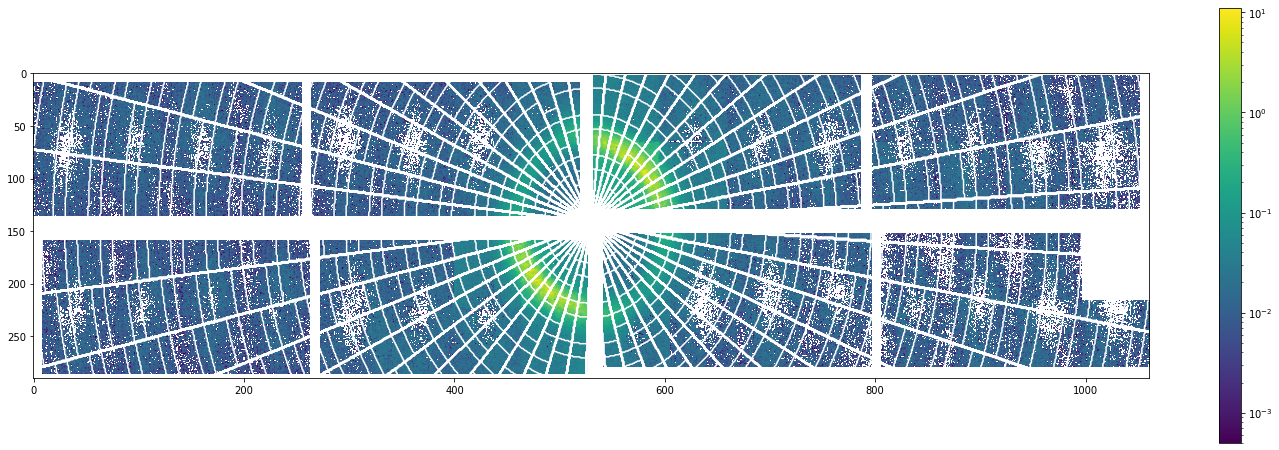

In [143]:
plt.figure(figsize=(25,10))
plt.imshow(img, norm=LogNorm())
plt.colorbar(shrink=0.8)
plt.plot(center[0], center[1], 'rx', markersize=20)
plt.contour(labels, colors=['w'], levels=1000)
plt.show()

In [144]:
module_labels = dssc_corrected_to_module_stack(labels.copy())
q_stacks = dssc_corrected_to_module_stack(q_discrete.copy())
angle_stacks = dssc_corrected_to_module_stack(angle_discrete.copy())

In [145]:
module_labels.shape

(4, 128, 512)

In [148]:
ds = xr.Dataset(
        data_vars={'labels': (('module', 'row', 'col'), module_labels),
                   'q_grid': (('module', 'row', 'col'), q_stacks),
                   'angle_grid': (('module', 'row', 'col'), angle_stacks)
                  },
        attrs={'run_number': run,
               'magnet_current': field,
               'module_order': modules,
               'date_processed': datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
              }
    )    
ds

<xarray.Dataset>
Dimensions:     (module: 4, row: 128, col: 512)
Dimensions without coordinates: module, row, col
Data variables:
    labels      (module, row, col) float64 310.0 310.0 310.0 ... 651.0 651.0
    q_grid      (module, row, col) float64 0.06177 0.06177 ... 0.2695 0.2695
    angle_grid  (module, row, col) float64 -1.601 -1.601 ... 0.06504 0.06504
Attributes:
    run_number:      70
    magnet_current:  0.0
    module_order:    [15, 0, 8, 7]
    date_processed:  09/19/2024, 23:13:17

In [149]:
ds.to_netcdf(f'./labels.h5', engine='h5netcdf')